### Imports

Required packages including those needed for `image_arrays.py` and `hdf_utils.py`.
- h5py
- numpy
- scipy
- matplotlib

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from matplotlib.patches import Rectangle

# local imports
from image_arrays import *
from hdf_utils import *

### Activate interactive plotting
By default, inline plots are static. Here we specify one of two options (comment out the undesired command) that will open plots with GUI controls for us.
- **qt ->** figures opened in windows outside the notebook
- **notebook ->** figures within notebook underneath generating cell.

In [2]:
# %matplotlib qt 
%matplotlib notebook

### Load triggered stimulus data

In [3]:
with h5.File("triggered_stimuli.h5") as f:
    d = unpack_hdf(f)

### Display noise stimulus used for this experiment / analysis
Use scroll wheel to cycle through the frames of the video (in frame steps set by the `delta` paramater of `StackExplorer`).

<IPython.core.display.Javascript object>


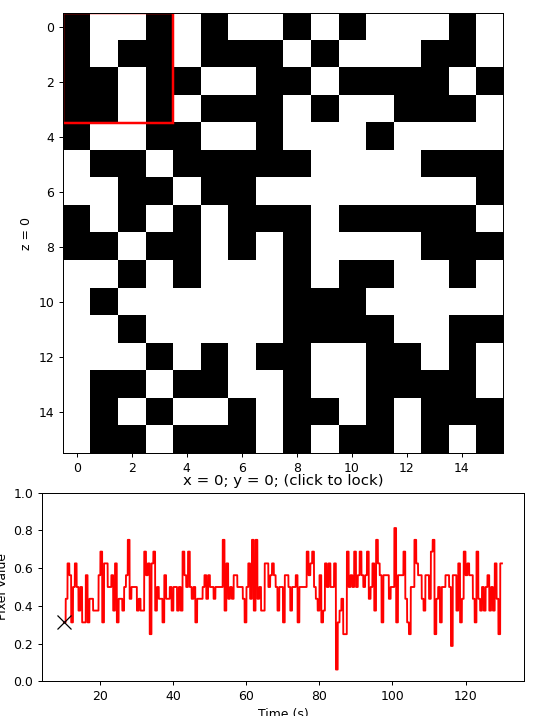

In [4]:
raw_noise_plot = StackExplorer(
    d["raw_noise"],
    zaxis=d["noise_xaxis"],
    delta=10,
    roi_sz=4,
    vmin=0,
    vmax=1,
    figsize=(6, 8)
)
raw_noise_plot.ax[1].set_xlabel("Time (s)")
raw_noise_plot.ax[1].set_ylabel("Pixel Value")

raw_noise_plot.fig.show()

### Dynamic ROI plot of recordings
Trial to display in the stack axis can be selected with the slider, with the last position being the average. Use mouse scroll to cycle through frames of the movies. Beams of the outlined ROI are displayed below with the current trial highlighted in red. The average beam is displayed with a thicker linewidth and greater opacity.

**NOTE:** If the recordings are large, this will use up a lot of RAM.

<IPython.core.display.Javascript object>


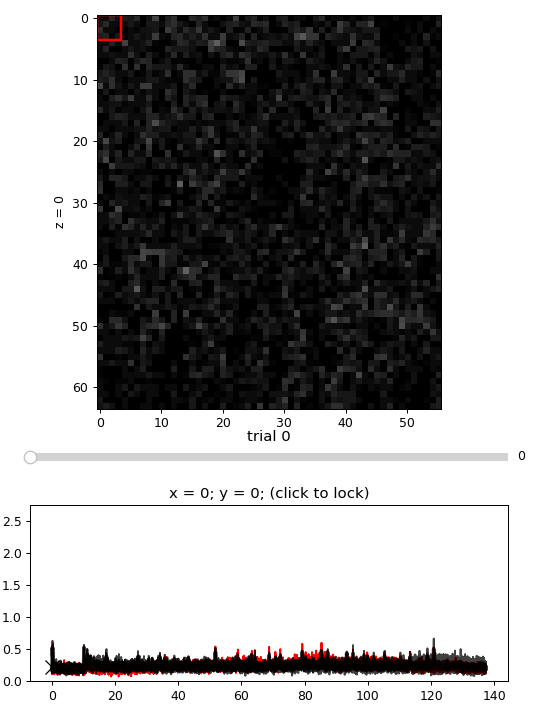

Recording shape: (8000, 64, 56)


In [5]:
stacks_plot = StackExplorer(
    d["recs"],
    zaxis=d["recs_xaxis"],
    delta=5,
    roi_sz=4,
    vmin=0,
    figsize=(6, 8)
)
stacks_plot.ax[1].set_xlabel("Time (s)")
stacks_plot.ax[1].set_ylabel("Pixel Value")

print("Recording shape:", d["recs"][0].shape)
stacks_plot.fig.show()

<IPython.core.display.Javascript object>


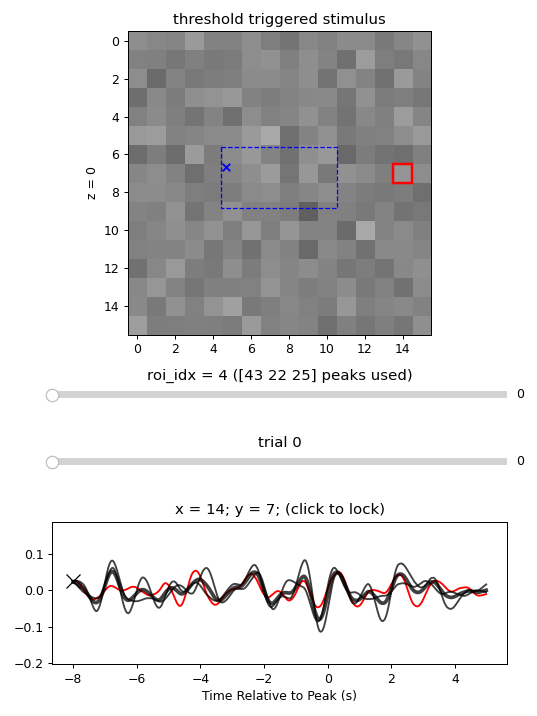

In [6]:
def roi_fmt_fun(i):
    return "roi_idx = %i (%s peaks used)" % (d["pos_to_roi"][i], str(d["n_peaks_used"][i]))

lead_stack_plot = StackExplorer(
#     d["lead"],"
    d["lead_conv"],
    zaxis=d["lead_xaxis"],
    delta=2,
    roi_sz=1,
#     vmin=0,
#     vmax=1,
    n_fmt_fun=roi_fmt_fun,
    figsize=(6, 8)
)
lead_stack_plot.stack_ax.set_title("threshold triggered stimulus")
lead_stack_plot.beam_ax.set_xlabel("Time Relative to Peak (s)")
lead_stack_plot.fig.tight_layout()

def scan_field_rect():
    return Rectangle(
        (d["x_corner_scaled"] - .5, d["y_corner_scaled"] - .5),  # grid offset
        d["rec_width"] / d["stim_width"] * d["raw_noise"].shape[2], 
        d["rec_height"] / d["stim_height"] * d["raw_noise"].shape[1], 
        fill=False,
        color="blue",
        linewidth=1,
        linestyle="--"
    )

def update_roi_mark(mark):
    def f(i):
#         idx = pos_to_roi[int(i)]
        x, y = d["roi_locs"][int(i)]
        x = (x * d["col_x"] + d["x_corner_phys"]) / d["stim_width"] * d["raw_noise"].shape[2] - 0.25
        y = (y * d["row_y"] + d["y_corner_phys"]) / d["stim_height"] * d["raw_noise"].shape[1] - 0.25
        mark.set_offsets([[x, y]])
    return f

lead_stack_plot.ax[0].add_patch(scan_field_rect())
lead_roi_mark = lead_stack_plot.ax[0].scatter([0], [0], marker="x", c="blue")
update_roi_mark(lead_roi_mark)(0)    
lead_stack_plot.n_slider.on_changed(update_roi_mark(lead_roi_mark))

lead_stack_plot.fig.show()
